# General Implementation of Grover Over Limited Search Space Using Dicke states (Oracle 1)
---

In [1]:
import networkx as nx
import numpy as np
import math
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import warnings
from random import choice, randint
import os
import re
from functools import reduce
import itertools
import more_itertools as mit
from IPython.display import IFrame
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
import operator as op
import csv
from qiskit.tools.visualization import plot_histogram
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
S_simulator = Aer.backends(name='statevector_simulator')[0]
M_simulator = Aer.backends(name='qasm_simulator')[0]

In [1]:
#A function to display results in a ket format (as descripted in arXiv:1903.04359v1)
def Measurement(quantumcircuit, *args, **kwargs): 
	#Displays the measurement results of a quantum circuit 
	p_M = True
	S = 1
	ref = False
	NL = False
	if 'shots' in kwargs:
		S = int(kwargs['shots'])
	if 'return_M' in kwargs:
		ret = kwargs['return_M']
	if 'print_M' in kwargs:
		p_M = kwargs['print_M']
	if 'column' in kwargs:
		NL = kwargs['column']
	M1 = execute(quantumcircuit, M_simulator, shots=S).result().get_counts(quantumcircuit)
	M2 = {}
	k1 = list(M1.keys())
	v1 = list(M1.values())
	for k in np.arange(len(k1)):
		key_list = list(k1[k])
		new_key = ''
		for j in np.arange(len(key_list)):
			new_key = new_key+key_list[len(key_list)-(j+1)]
		M2[new_key] = v1[k]
	if(p_M):
		k2 = list(M2.keys())
		v2 = list(M2.values())
		measurements = ''
		for i in np.arange(len(k2)):
			m_str = str(v2[i])+'|'
			for j in np.arange(len(k2[i])):
				if(k2[i][j] == '0'):
					m_str = m_str + '0' 
				if(k2[i][j] == '1'):
					m_str = m_str + '1'
				if( k2[i][j] == ' ' ):
					m_str = m_str +'>|'
			m_str = m_str + '>   '
			if(NL):
				m_str = m_str + '\n'
			measurements = measurements + m_str
		#print(measurements)
		return measurements
	if(ref):
		return M2

# Get graph from list of edges
---

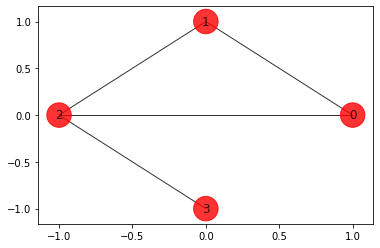

In [2]:
#Produce a graph from a list of edges
#The edges list must be ordered as in, all edges from node 0 then 1 then 2 and so on...
G = nx.Graph()
default_axes = plt.axes(frameon=True)
#4nodes, triangle
edges = [(0, 1), (2, 3), (0, 2), (1, 2)]#The graph we used so far
#8nodes, 4node-clique
#edges = [(0, 1), (2, 3), (0, 2), (1, 2),(0,3),(0,4),(1,3),(3,4),(3,6),(4,6),(4,5),(5,6),(6,7)]
#5nodes, 4 nodes clique
#edges = [(0,1),(0,2),(0,3),(1,2),(1,3),(1,4),(2,3),(3,4)]
#1- Find number of nodes based on a given list of edges
#edges = [(0, 1), (2, 3), (0, 2), (1, 2), (0, 3)]
n_nodes = len(set(itertools.chain.from_iterable(edges))) 
#2- Draw graph based on number of nodes and edges
G.add_edges_from(edges)
G.add_nodes_from(range(n_nodes))
G.add_edges_from(edges)
colors = ['r' for node in G.nodes()]
pos = nx.shell_layout(G)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

# Define the Dicke State generation functions
---

In [3]:
#Implementation of dicke state as described in arXiv:1904.07358v1
def scs(qc,qubits,n,l):
    #the qubits will be inputed from buttom to top
    #print(math.sqrt(l/n))
    if len(qubits) == 2:
        qc.cx(qubits[1],qubits[0])
        theta = 2*(math.acos(math.sqrt(l/n)))
        qc.cry(theta,qubits[0],qubits[1])
        qc.cx(qubits[1],qubits[0])
    elif len(qubits) == 3:
        qc.cx(qubits[2],qubits[0])
        theta = 2*(math.acos(math.sqrt(l/n)))
        qc.mcry(theta, [qubits[0],qubits[1]],qubits[2], None)
        qc.cx(qubits[2],qubits[0])
    else:
        raise CircuitError("Unvalid number of qubits")
    qc.barrier()
    return qc

def dicke(qc,qubits,n,k):
    qc.x(qubits[n-k:])
    d = {}
    l = 1
    while l<=k:
        if n == k:
            k -= 1
        else:
            t = []
            for i in range(1,k+1):
                if i == 1:
                    t.append([n-1,n-i-1])
                else:
                    t.append([n-1,n-i,n-i-1])
            d[str(n)+str(k)] = t #[::-1]
            n -= 1
    d["32"] = [[2,1],[2,1,0]]
    d["21"] = [[1,0]]
#===============================================================
    for key in d.keys():
        item = d[key]
        l = 1
        for sub in item:
            fn_in = []
            #print("=========================")
            #print(sub)
            for i in sub:
                fn_in = [qubits[i] for i in sub]
            #print(int(key[0]),l)
            #print(fn_in)
            qc = scs(qc,fn_in,int(key[0]),l)
            l += 1        
    return qc

# State Preparation
---

In [4]:
#### the size of the clique
k = 3 
sub_qbits = QuantumRegister(n_nodes)
sub_cir = QuantumCircuit(sub_qbits,name="state")
sub_cir = dicke(sub_cir,sub_qbits,n_nodes,k)
stat_prep = sub_cir.to_instruction()
inv_stat_prep = sub_cir.inverse().to_instruction()
state_prep_size = sub_cir.decompose().size()-1
print("total number of operations in the circuit.")
print(sub_cir.size())
print("depth of circuit (number of ops on the critical path)")
print(sub_cir.depth())
print("a breakdown of operations by type")
print(sub_cir.count_ops())

total number of operations in the circuit.
30
depth of circuit (number of ops on the critical path)
28
a breakdown of operations by type
OrderedDict([('cx', 12), ('barrier', 6), ('u3', 6), ('ccx', 6), ('x', 3), ('cry', 3)])


# Define cz gate
---

In [6]:
def cnz(qc, num_control, node, anc):
    """
    num_control :  number of control qubit of cnz gate
    node :             node qubit
    anc :               ancillaly qubit
    """
    if num_control>2:
        qc.ccx(node[0], node[1], anc[0])
        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.cz(anc[num_control-2], node[num_control])
        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.ccx(node[0], node[1], anc[0])
    if num_control==2:
        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])
    if num_control==1:
        qc.cz(node[0], node[1])

# The Diff operator
---

In [7]:
def grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep):
    qc.append(inv_stat_prep,qargs=nodes_qubits)
    qc.x(nodes_qubits)
    #====================================================
        #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    qc.x(nodes_qubits)
    qc.append(stat_prep,qargs=nodes_qubits)  

# The Oracle
---

In [8]:
def edge_counter(qc,qubits,anc,flag_qubit,k):
    bin_k = bin(k)[2:][::-1]
    l = []
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    qc.mct(l,flag_qubit,[anc])

In [9]:
def oracle(k,n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base):
    #1- edge counter
    #forward circuit
    qc.barrier()
    qc.ccx(nodes_qubits[edges[0][0]],nodes_qubits[edges[0][1]],edge_anc[0])
    if len(edge_anc) == 2:
        for i in range(1, len(edges)):
            qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0]],edge_anc[1], [ancilla[0]])
            qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]], edge_anc[0])
    elif len(edge_anc) == 3:
        for i in range(1, len(edges)):
            qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0], edge_anc[1]], edge_anc[2], 
                     [ancilla[0],ancilla[1]])
            qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0]], edge_anc[1], [ancilla[0]])
            qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]], edge_anc[0])
    #----------------------------------------------------------------------------------------------------------
    #Edges check Qubit
    edg_k = int((k/2)*(k-1))
    edge_counter(qc,edge_anc,ancilla[0],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------
    #Reverse edge count
    if len(edge_anc) == 2:
        for i in range(len(edges)-1,0,-1):
            qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0])
            qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0]],edge_anc[1], [ancilla[0]])
    elif len(edge_anc) == 3:
        for i in range(len(edges)-1,0,-1):
            qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]], edge_anc[0])
            qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0]], edge_anc[1], [ancilla[0]])
            qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0], edge_anc[1]], edge_anc[2], 
                     [ancilla[0],ancilla[1]])
    qc.ccx(nodes_qubits[edges[0][0]],nodes_qubits[edges[0][1]],edge_anc[0])
    qc.barrier()

# The Algorithm
---

In [10]:
# Grover algo function
def grover(x,k,n_nodes,stat_prep,inv_stat_prep): # X >> Number of iterations
    N = 2**n_nodes  # for optimal iterations count
    P = len(bin(k)[2:])
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(P, name='edge_anc')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(1, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(1, name='tri_flag')
    qc = QuantumCircuit(nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag)
    # Initialize qunatum flag qubits in |-> state
    qc.x(neg_base)
    qc.h(neg_base)
    # Initializing i/p qubits in superposition
    qc.append(stat_prep,qargs=nodes_qubits)
    qc.barrier()
    # Calculate iteration count
    for i in np.arange(x):
        qc.barrier()
        oracle(k,n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep)
    return qc, nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag

# Optimal iterations
---

In [9]:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

In [10]:
N_opt_iter = ncr(n_nodes,k) #The new sub-Hilbert space size depending on the number of nodes and the clique size
opt_iter = math.floor(math.pi/4*math.sqrt(N_opt_iter))
print(opt_iter)

1


# For different iterations
---

In [11]:
l = [] #a list to store different number of iterations results
data = []
for i in range(1,2): #Observing the algorithm behaviour for different iterations, optimal iternation is 1
    qc, nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag = grover(i,k,n_nodes,stat_prep,inv_stat_prep)
    qc.measure(nodes_qubits,class_bits)
    #Executing circuit and show results
    ex = execute(qc, M_simulator, shots = 5000)
    res = ex.result()
    M = res.get_counts(qc)
    #printing measurements results
    s = oq.Measurement(qc,shots=5000)   
    pattern = "\d+\|\d+\>"
    res = re.findall(pattern,s)
    dct = {}
    for item in res:
        if item[item.index("|"):] not in dct.keys():
            dct[item[item.index("|"):]] = int(item[:item.index("|")]) 
        else:
            dct[item[item.index("|"):]] += int(item[:item.index("|")]) 
    l.append(dct)
    #print(dct)
    print("===========================")
    print("at "+str(i)+" Iterations")
    #print(dct)
    print("total number of operations in the circuit.")  
    print(qc.size())
    print("depth of circuit (number of ops on the critical path)")
    print(qc.depth())
    print("number of qubits in the circuit")
    print(len(qc.qubits))
    print("a breakdown of operations by type")
    print(qc.decompose().count_ops())
    data.append([str(i),str(qc.size()),str(qc.depth()),str(len(qc.qubits)),qc.count_ops()])


at 1 Iterations
total number of operations in the circuit.
37
depth of circuit (number of ops on the critical path)
27
number of qubits in the circuit
9
a breakdown of operations by type
OrderedDict([('cx', 115), ('t', 52), ('h', 40), ('tdg', 39), ('u3', 27), ('barrier', 23), ('ccx', 18), ('x', 9), ('cry', 9), ('mcu1', 6), ('measure', 4), ('u2', 1)])


# Results
---

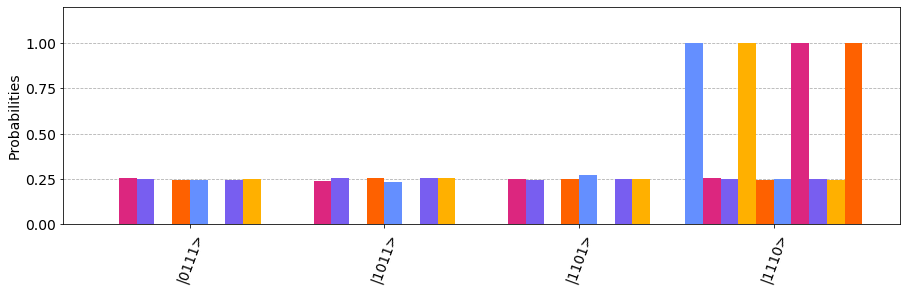

In [21]:
#Comparing 5 iterations
plot_histogram(l, bar_labels=False,figsize=(15, 4))